# 15.11.2024

In [1]:
import math
import numpy as np
import scipy.stats as sps 
import scipy.optimize
from tqdm import trange
import matplotlib.pyplot as plt
from collections.abc import Iterable, Sequence

In [2]:
N = 10 ** 3
KS = list(range(1, 3+1))
A = (0.0, 1.0, 1.0)
QS = [0.95, 0.99, 0.999]
SAMPLE_SIZE = 30
STD = 0.05
uniform_boundary = (3 * STD) / math.sqrt(3)
laplace_lambda = STD / math.sqrt(2)
EPS_DISTR = {"Norm":    sps.norm(loc=0, scale=STD),
             "Uniform": sps.uniform(loc=-uniform_boundary, scale=2 * uniform_boundary),
             "Laplace": sps.laplace(loc=0, scale = laplace_lambda)}

Проверим, что это действительно случайные величины с СКО равным $0.05$

In [3]:
for d in EPS_DISTR:
    print(f"{d}: E[r] = {EPS_DISTR[d].stats('m')}, Var[r] = {EPS_DISTR[d].stats('v'):.5f}, STD = {math.sqrt(EPS_DISTR[d].stats('v')):.3f}")

Norm: E[r] = 0.0, Var[r] = 0.00250, STD = 0.050
Uniform: E[r] = 0.0, Var[r] = 0.00250, STD = 0.050
Laplace: E[r] = 0.0, Var[r] = 0.00250, STD = 0.050


Наша функция $f$, параметры которой мы хотим оценить $$f(x, \vec{a}) = \frac{x a_1 + a_0}{x + a_2}$$

In [4]:
def f(x: Iterable[float] | float, a: Sequence[float]) -> np.ndarray[float] | float:
    try:
        return np.array([(x_ * a[1] + a[0]) / (x_ + a[2]) for x_ in x])
    except:
        return (x * a[1] + a[0]) / (x + a[2])

Зададим метрики функционала невязки, которые мы хотим минимизировать для каждой регрессии

In [5]:
def ols(a, xs, ys):
    return sum((np.array(ys) - f(xs, a)) ** 2)

def lad(a, xs, ys):
    return sum(np.abs(np.array(ys) - f(xs, a)))

Будем минимизировать их с помощью `scipy.optimize.minimize`

In [6]:
def fit_regression(regression, xs, ys):
    return scipy.optimize.minimize(regression, A, args=(xs, ys)).x

In [7]:
REGRESSIONS = {"OLS": ols,
               "LAD": lad}

In [8]:
XS = np.linspace(0.1, 3.0, num=SAMPLE_SIZE)

In [9]:
def get_residuals(x_data, y_data, a_est):
    return np.array(y_data) - f(x_data, a_est)

In [10]:
def get_studentized_residuals(x_data, y_data: np.ndarray, a_est):
    residuals = get_residuals(x_data, y_data, a_est)
    X = np.column_stack((np.ones_like(x_data), x_data))  # Include intercept term (constant)
    X_inv = np.linalg.inv(X.T @ X)  # Inverse of (X' * X)
    leverage = np.diagonal(X @ X_inv @ X.T)

    # Calculate the studentized residuals: r_i / sqrt(MSE * (1 - h_ii))
    # We estimate MSE (mean squared error) as the sum of squared residuals divided by the degrees of freedom (n - p)
    mse = np.sum(residuals ** 2) / (len(x_data) - 3)  # Degrees of freedom: n - p (with p = 3 parameters)

    # Studentized residuals
    studentized_residuals = residuals / np.sqrt(mse * (1 - leverage))
    return studentized_residuals

In [11]:
def R_2(xs, ys, a_est):
    return sum(get_residuals(xs, ys, a_est) ** 2)

In [12]:
def compare_coeffs(a_1, a_2):
    return sum((np.array(a_1) - np.array(a_2)) ** 2)

In [13]:
def detect_outliers(x, y, true_outlier_indices, verbose = False):
    cur_XS = x.copy()
    cur_YS = y.copy()
    if verbose:
        print(f'{len(true_outlier_indices)} outliers injected at {true_outlier_indices}')
    regression_coeffs_OLS = fit_regression(REGRESSIONS['OLS'], cur_XS, cur_YS)
    regression_coeffs_LAD = fit_regression(REGRESSIONS['LAD'], cur_XS, cur_YS)
    prev_norm = compare_coeffs(regression_coeffs_OLS, regression_coeffs_LAD)
    if verbose:
        print(f'Before outlier removal ||a_OLS - a_LAD|| = {prev_norm}')
    detected_outlier_values = np.array([])
    detected_outlier_original_indeces = np.array([])
    detected_true_outlier_original_indeces = np.array([])
    it = 1
    if verbose:
        print('-'*100)
    while True:
        if verbose:
            print(f'Iteration {it}:\nx of length {len(cur_XS)}\ny of length {len(cur_YS)}')
        studentized_residuals = get_studentized_residuals(cur_XS, cur_YS, regression_coeffs_OLS)
        studentized_residuals = np.abs(studentized_residuals) 

        new_outlier_index = np.argmax(studentized_residuals)
        new_outlier_value = cur_YS[new_outlier_index]
        new_outlier_original_index = np.where(y == new_outlier_value)[0]

        detected_outlier_values = np.append(detected_outlier_values, new_outlier_value)
        detected_outlier_original_indeces = np.append(detected_outlier_original_indeces, new_outlier_original_index)

        if new_outlier_original_index in true_outlier_indices:
            detected_true_outlier_original_indeces = np.append(detected_true_outlier_original_indeces, new_outlier_original_index)

        cur_XS = np.delete(cur_XS, new_outlier_index)
        cur_YS = np.delete(cur_YS, new_outlier_index)

        regression_coeffs_OLS = fit_regression(REGRESSIONS['OLS'], cur_XS, cur_YS)
        regression_coeffs_LAD = fit_regression(REGRESSIONS['LAD'], cur_XS, cur_YS)

        cur_norm = compare_coeffs(regression_coeffs_OLS, regression_coeffs_LAD)
        if cur_norm < prev_norm:
            prev_norm = cur_norm
            if verbose:
                print(f'Outliers detected at {detected_outlier_original_indeces}, true outliers are at {true_outlier_indices}, detected true outliers: {detected_true_outlier_original_indeces}')
                print(f'||a_OLS - a_LAD|| = {cur_norm}')
                print('-'*100)
        else:
            detected_true_outlier_original_indeces = np.intersect1d(true_outlier_indices, detected_outlier_original_indeces)
            detected_outlier_original_indeces = np.delete(detected_outlier_original_indeces, np.where(detected_outlier_original_indeces == new_outlier_original_index)).astype(np.int32)
            if verbose:
                print(f'Norm worsened. {prev_norm} -> {cur_norm}')
                print(f"Removing new outlier {new_outlier_original_index} from detected_outlier_indices = {detected_outlier_original_indeces}")
                print('-'*100)
            break
    return detected_outlier_original_indeces

In [14]:
fn = {k: {} for k in KS}
fp = {k: {} for k in KS}
eps = 'Norm'
for k in KS:
    for q in QS:
        false_negative = 0
        false_positive = 0
        for _ in trange(N):
            YS = f(XS, A) + EPS_DISTR[eps].rvs(SAMPLE_SIZE)
            true_outlier_indices = np.random.choice(range(SAMPLE_SIZE), k, replace=False)
            YS[true_outlier_indices] += EPS_DISTR[eps].ppf(q)

            outliers_indeces = set(detect_outliers(XS, YS, true_outlier_indices, verbose=False))
            true_outlier_indices = set(true_outlier_indices)

            false_negative += len(true_outlier_indices - outliers_indeces)
            false_positive += len(outliers_indeces - true_outlier_indices)
        false_positive = false_positive / (N * k)
        false_negative = false_negative / (N * k)
        fn[k][q] = false_negative
        fp[k][q] = false_positive
        print(f'For {k} outlier{"s" if k > 1 else ""} as {q * 100 if abs(round(q*100)-(q*100)) > 0 else round(q * 100)}%-th quantile on avarage {(false_negative * 100):.2f}% values were not found as outliers and {(false_positive * 100):.2f}% were wrongly considered outliers.')

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:15<00:00, 13.27it/s]


For 1 outlier as 95%-th quantile on avarage 84.40% values were not found as outliers and 74.40% were wrongly considered outliers.


100%|██████████| 1000/1000 [01:17<00:00, 12.94it/s]


For 1 outlier as 99%-th quantile on avarage 69.30% values were not found as outliers and 60.10% were wrongly considered outliers.


100%|██████████| 1000/1000 [01:17<00:00, 12.92it/s]


For 1 outlier as 99.9%-th quantile on avarage 54.60% values were not found as outliers and 49.60% were wrongly considered outliers.


100%|██████████| 1000/1000 [01:28<00:00, 11.33it/s]


For 2 outliers as 95%-th quantile on avarage 85.85% values were not found as outliers and 29.05% were wrongly considered outliers.


100%|██████████| 1000/1000 [01:16<00:00, 13.11it/s]


For 2 outliers as 99%-th quantile on avarage 77.30% values were not found as outliers and 20.05% were wrongly considered outliers.


100%|██████████| 1000/1000 [01:16<00:00, 13.00it/s]


For 2 outliers as 99.9%-th quantile on avarage 66.70% values were not found as outliers and 13.95% were wrongly considered outliers.


100%|██████████| 1000/1000 [01:14<00:00, 13.34it/s]


For 3 outliers as 95%-th quantile on avarage 86.57% values were not found as outliers and 15.97% were wrongly considered outliers.


100%|██████████| 1000/1000 [01:15<00:00, 13.18it/s]


For 3 outliers as 99%-th quantile on avarage 81.10% values were not found as outliers and 12.60% were wrongly considered outliers.


100%|██████████| 1000/1000 [01:15<00:00, 13.20it/s]

For 3 outliers as 99.9%-th quantile on avarage 74.40% values were not found as outliers and 5.87% were wrongly considered outliers.


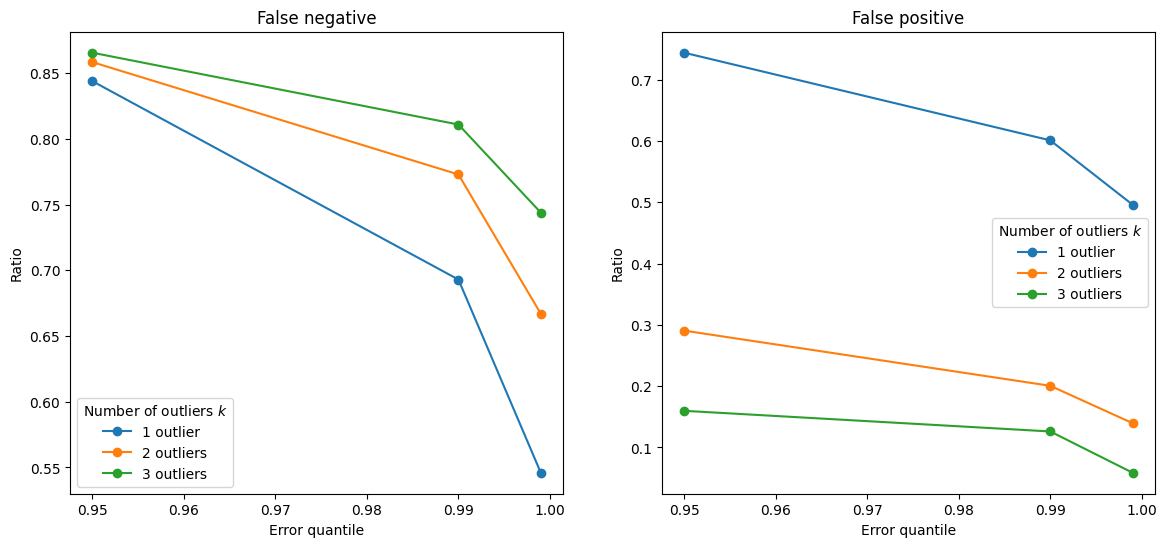

In [15]:
_, axes = plt.subplots(1, 2, figsize=(14, 6))
for i, (name, res) in enumerate({'False negative': fn, 'False positive': fp}.items()):
    ax: plt.Axes = axes[i]
    ax.title.set_text(name)
    ax.set_xlabel('Error quantile')
    ax.set_ylabel('Ratio')
    for k_id, k in enumerate(KS):
        d = res[k]
        ax.plot(d.keys(), d.values(), '-o', color='C'+str(k_id), label=f'{k} outliers' if k > 1 else '1 outlier')
        ax.legend(title='Number of outliers $k$')
plt.show()